In [1]:
from skimage import io
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib

In [2]:
def read_landmark_file(file_name):
    f = open(file_name, 'r')
    lm_s = f.readline().strip().split(' ')
    n_lms = int(lm_s[0])
    if n_lms < 3:
        print(f"Not enough landmarks found")
        return None

    new_lms = 3
    # 3 landmarks each with (x,y)
    lm = np.zeros((new_lms, 2))
    for i in range(new_lms):
        lm[i, 0] = lm_s[1 + i * 2]
        lm[i, 1] = lm_s[2 + i * 2]
    return lm
def align_and_crop_one_cat_to_destination_cat(img_src, lm_src, img_dst, lm_dst):
    """
    Landmark based alignment of one cat image to a destination
    :param img_src: Image of source cat
    :param lm_src: Landmarks for source cat
    :param lm_dst: Landmarks for destination cat
    :return: Warped and cropped source image. None if something did not work
    """
    tform = SimilarityTransform()
    tform.estimate(lm_src, lm_dst)
    warped = warp(img_src, tform.inverse, output_shape=img_dst.shape)

    # Center of crop region
    cy = 185
    cx = 210
    # half the size of the crop box
    sz = 180
    warp_crop = warped[cy - sz:cy + sz, cx - sz:cx + sz]
    shape = warp_crop.shape
    if shape[0] == sz * 2 and shape[1] == sz * 2:
        return img_as_ubyte(warp_crop)
    else:
        print(f"Could not crop image. It has shape {shape}. Probably to close to border of image")
        return None
def preprocess_all_cats(in_dir, out_dir):
    """
    Create aligned and cropped version of image
    :param in_dir: Where are the original photos and landmark files
    :param out_dir: Where should the preprocessed files be placed
    """
    dst = "data/ModelCat"
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")
    dst_img = io.imread(f"{dst}.jpg")

    all_images = glob.glob(in_dir + "*.jpg")
    for img_idx in all_images:
        name_no_ext = os.path.splitext(img_idx)[0]
        base_name = os.path.basename(name_no_ext)
        out_name = f"{out_dir}/{base_name}_preprocessed.jpg"

        src_lm = read_landmark_file(f"{name_no_ext}.jpg.cat")
        src_img = io.imread(f"{name_no_ext}.jpg")

        proc_img = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
        if proc_img is not None:
            io.imsave(out_name, proc_img)
def preprocess_one_cat():
    src = "data/MissingCat"
    dst = "data/ModelCat"
    out = "data/MissingCatProcessed.jpg"

    src_lm = read_landmark_file(f"{src}.jpg.cat")
    dst_lm = read_landmark_file(f"{dst}.jpg.cat")

    src_img = io.imread(f"{src}.jpg")
    dst_img = io.imread(f"{dst}.jpg")

    src_proc = align_and_crop_one_cat_to_destination_cat(src_img, src_lm, dst_img, dst_lm)
    if src_proc is None:
        return

    io.imsave(out, src_proc)

    fig, ax = plt.subplots(ncols=3, figsize=(16, 6))
    ax[0].imshow(src_img)
    ax[0].plot(src_lm[:, 0], src_lm[:, 1], '.r', markersize=12)
    ax[1].imshow(dst_img)
    ax[1].plot(dst_lm[:, 0], dst_lm[:, 1], '.r', markersize=12)
    ax[2].imshow(src_proc)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()
def create_u_byte_image_from_vector(im_vec, height, width, channels):
    min_val = im_vec.min()
    max_val = im_vec.max()

    # Transform to [0, 1]
    im_vec = np.subtract(im_vec, min_val)
    im_vec = np.divide(im_vec, max_val - min_val)
    im_vec = im_vec.reshape(height, width, channels)
    im_out = img_as_ubyte(im_vec)
    return im_out

In [5]:
preprocess_all_cats('training_data/','data/processed')

In [6]:
files = glob.glob("data/processed/*.jpg")

height, width, channels = io.imread(files[0]).shape
data_matrix = np.zeros((len(files), height * width * channels))
for i, f in enumerate(files):
    data_matrix[i, :] = io.imread(f).flatten()

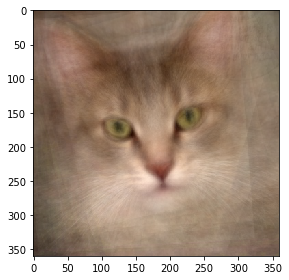

In [12]:
meancat = np.mean(data_matrix, axis=0)
meanimg = create_u_byte_image_from_vector(meancat,height,width,channels)
io.imshow(meanimg)

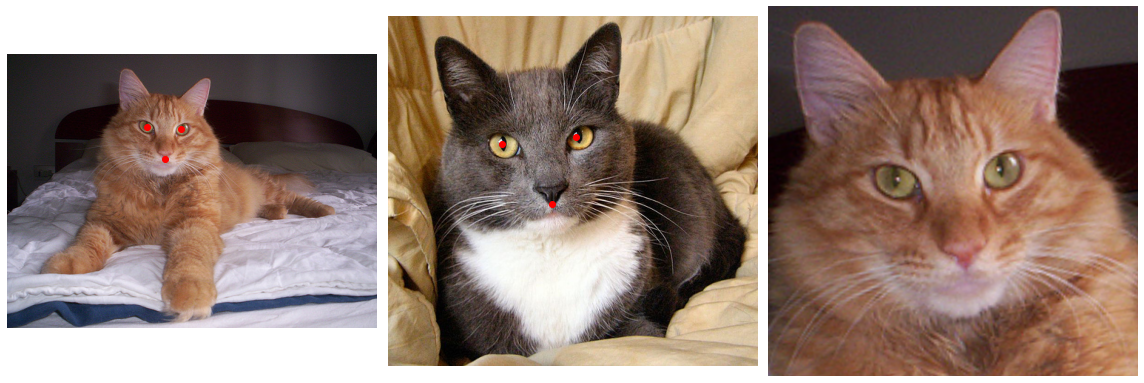

In [13]:
preprocess_one_cat()

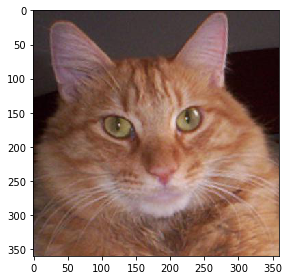

In [20]:
mc = io.imread('data/MissingCatProcessed.jpg')
io.imshow(mc)
io.show
mcflat = mc.flatten()

In [15]:
sub_data = data_matrix - mcflat
sub_distances = np.linalg.norm(sub_data, axis=1)

32


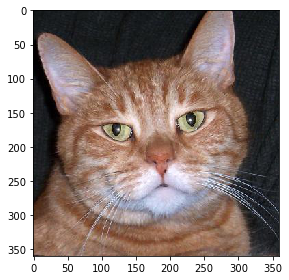

In [19]:
closecat = np.argmin(sub_distances)
print(closecat)
closecatimg = create_u_byte_image_from_vector(data_matrix[closecat],height,width,channels)
io.imshow(closecatimg)

9


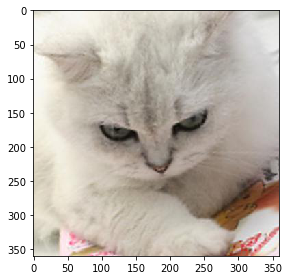

In [21]:
notclosecat = np.argmax(sub_distances)
print(notclosecat)
notclosecatimg = create_u_byte_image_from_vector(data_matrix[notclosecat],height,width,channels)
io.imshow(notclosecatimg)

In [22]:
print("Computing PCA")
cats_pca = PCA(n_components=50)
cats_pca.fit(data_matrix)

Computing PCA


PCA(n_components=50)

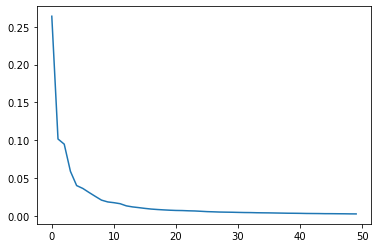

In [27]:
plt.plot(cats_pca.explained_variance_ratio_)

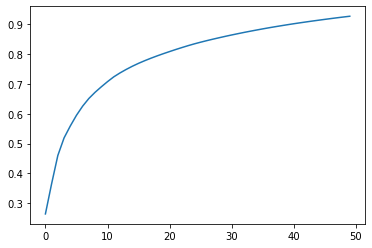

In [28]:
plt.plot(cats_pca.explained_variance_ratio_.cumsum())

In [35]:
print("The first component explains {:.2f}% of the variance".format(cats_pca.explained_variance_ratio_[0] * 100))

The first component explains 26.38% of the variance


In [36]:
components = cats_pca.transform(data_matrix)

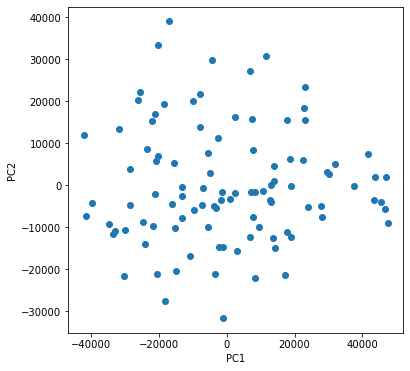

In [38]:
pc_1 = components[:, 0] 
pc_2 = components[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(pc_1, pc_2, "o")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [39]:
def nargmax(arr, n):
    # Like np.argmax but returns the n largest values
    idx = np.argpartition(arr, -n)[-n:]
    return idx[np.argsort(arr[idx])][::-1]

def nargmin(arr, n):
    # Like np.argmin but returns the n smallest values
    idx = np.argpartition(arr, n)[:n]
    return idx[np.argsort(arr[idx])]

def plot_pca_space_and_img(pc_idx):
    _, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].plot(pc_1, pc_2, "o")
    ax[0].plot(pc_1[pc_idx], pc_2[pc_idx], "ro", markersize=10)
    ax[0].set_xlabel("PC1")
    ax[0].set_ylabel("PC2")
    
    img = create_u_byte_image_from_vector(data_matrix[pc_idx, :], height, width, channels)
    ax[1].imshow(img)
    ax[1].set_title("Cat")
    ax[1].set_axis_off()
    plt.show()

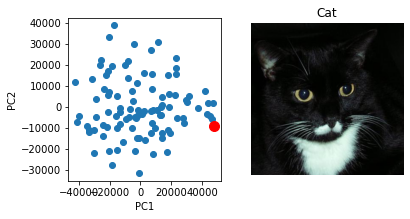

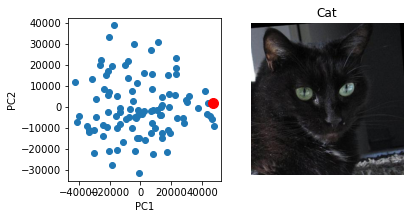

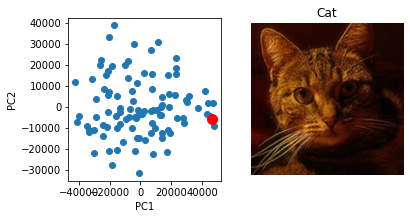

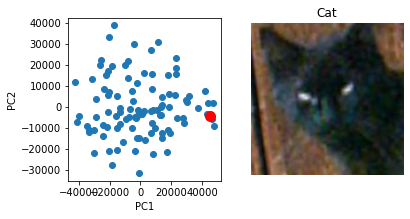

In [40]:
max_pc1s = nargmax(pc_1, 4)
for i in max_pc1s:
    plot_pca_space_and_img(i)

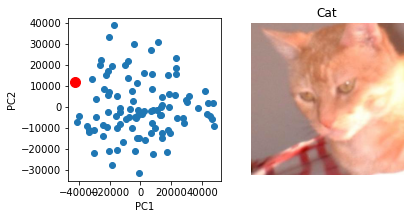

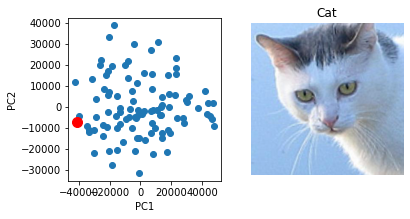

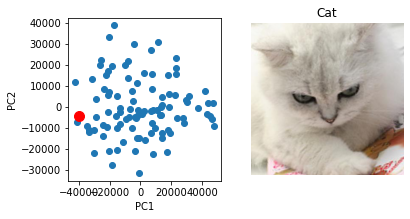

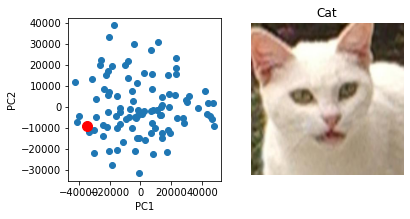

In [41]:
min_pc1s = nargmin(pc_1, 4)
for i in min_pc1s:
    plot_pca_space_and_img(i)

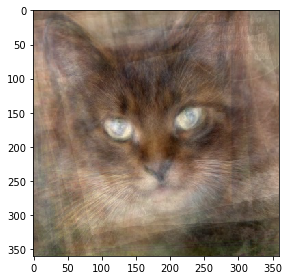

In [47]:
w = 60000
synth_cat = meancat + w * cats_pca.components_[0, :]
synthimg = create_u_byte_image_from_vector(synth_cat,height,width,channels)
io.imshow(synthimg)

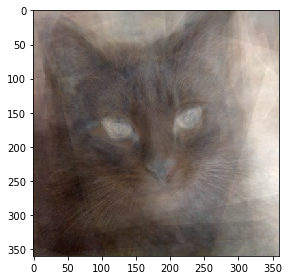

In [50]:
w = 60000
w2 = 60000
synth_cat = meancat + w * cats_pca.components_[0, :] + w2 * cats_pca.components_[1,:]
synthimg = create_u_byte_image_from_vector(synth_cat,height,width,channels)
io.imshow(synthimg)

In [51]:
import random
n_components_to_use = 10
synth_cat = meancat
for idx in range(n_components_to_use):
	w = random.uniform(-1, 1) * 3 * np.sqrt(cats_pca.explained_variance_[idx])
	synth_cat = synth_cat + w * cats_pca.components_[idx, :]